In [1]:
import deepcut
import sefr_cut
from sefr_cut.preprocessing import preprocess
import sefr_cut.extract_features as extract_features

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pickle
import math
import copy as cp
from itertools import accumulate
import operator

import pycrfsuite

# Define Function

In [2]:
def return_max_index(number_ranking,entropy_list):
    index_entropy = []
    func_entro_list = entropy_list[:]
    ranking_ = int(len(entropy_list)*(number_ranking/100))
    for i in range(ranking_):
        index, max_num = max(enumerate(func_entro_list), key=operator.itemgetter(1))
        func_entro_list[index] = -math.inf
        index_entropy.append(index)
    return index_entropy

def scoring_function_crf(y_pred, index, y_entropy, y_prob, crf_model_ds):
    result = y_pred[:]
    for i,items in enumerate(index):
        x_data = extract_features.extract_features_crf(x[i],i,y_entropy, y_prob)
        for idx in items:
            y_pred_crf = crf_model_ds.tag(x_data[idx])
            result[i][idx] = int(y_pred_crf[0])
    return result

def score_(K_num,start,step, y_true, y_pred, y_entropy, y_prob, crf_model_ds):
    K_num+=step
    f1_original = []
    f1_crf_og=[]
    f1_hypothesis=[]
    y_true_data = [j for sub in y_true for j in sub]
    y_original_data = [j for sub in y_pred for j in sub]
    for K in range(start,K_num,step):
        entropy_index_og = [return_max_index(K,value) for value in y_entropy] # Find entropy index from DC Baseline
        
        answer_crf_original = scoring_function_crf(cp.deepcopy(y_pred), entropy_index_og, y_entropy, y_prob, crf_model_ds) # DeepCut+CRF
        y_test_data = [j for sub in answer_crf_original for j in sub] #2d to 1d
        
        f1_original.append(eval_function([y_true_data],[y_original_data])) # F1 DeepCut
        f1_crf_og.append(eval_function([y_true_data],[y_test_data]))# F1 CRF+DeepCut
        
        # If you want to know how perfect of filter and refine you can use this function
        #answer = scoring_function(y_true,cp.deepcopy(y_pred),entropy_index_og)
        #f1_hypothesis.append(eval_function(y_true,answer))
        
        
    #%matplotlib notebook
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_xlabel('K percentage candidate',fontsize=18)
    ax.set_ylabel('F1 Score Character level',fontsize=18)
    
    # for perfect filter and refine only
    #ax.plot(range(start,K_num,step),f1_hypothesis,c="r",marker='o',label='Best case')
    
    ax.plot(range(start,K_num,step),f1_original,c="k",label='DeepCut')
    ax.plot(range(start,K_num,step),f1_crf_og,c="g",marker='v',label='SE+DeepCut')
    
    #ax.legend(loc='center right')
    ax.legend()
    plt.show()
    
    return f1_original,f1_crf_og

def SERF_CUT(entropy_y, y_deepcut, y_prob, K_num, crf_model_ds):
    entropy_index = [return_max_index(K_num,value) for value in entropy_y]
    answer_crf = scoring_function_crf(cp.deepcopy(y_deepcut), entropy_index, entropy_y, y_prob, crf_model_ds)
    return answer_crf

def cut(y_pred_boolean, x_data):
    x_ = cp.deepcopy(x_data)
    answer = []
    for idx,items in enumerate(y_pred_boolean):
        text = ""
        for index,item in enumerate(items):
            if(item == 1):
                text +='|'
            text +=x_[idx][index]
        answer.append(text)
    return answer 

def evaluate_word(train : list, test: list) -> tuple:
    train_acc = list(accumulate(map(len, train), func = operator.add))
    test_acc = list(accumulate(map(len, test), func = operator.add))
    train_set = set(zip([0,*train_acc], train_acc))
    test_set = set(zip([0,*test_acc], test_acc))
    correct = len(train_set & test_set)
    pre = correct/len(test)
    re = correct/len(test)
    f1 = (2*pre*re)/(pre+re)
    return f1

# in filter and refine evaluation we use F1-score character level
def eval_function(y_true,y_pred):
    f1_score_entropy=[]; 
    for index,_ in enumerate(y_pred):
        precision, recall, fscore, _ = precision_recall_fscore_support(y_true[index], y_pred[index], average='binary')
        f1_score_entropy.append(fscore)
    return np.mean(f1_score_entropy)

def visual_wrong_word(train, test):
    train_acc = list(accumulate(map(len, train), func = operator.add))
    test_acc = list(accumulate(map(len, test), func = operator.add))
    train_set = set(zip([0,*train_acc], train_acc))
    test_set = set(zip([0,*test_acc], test_acc))

    true_pred = train_set & test_set
    wrong_pred = train_set - true_pred

    return list(wrong_pred)

# Load model

In [3]:
#For tokenize entire pipeline
model_path = 'model/my_model.model'
sefr_cut.SEFR_CUT.load_model(engine='my_model', model_path=model_path)

loading model.....
Success


In [4]:
#For evaluation part
crf_model_ds = pycrfsuite.Tagger() 
crf_model_ds.open(model_path)

In [5]:
#Load custom dict for deepcut in test compare part
custom_dict_path = 'corpus/TH_transliteration/TH_transliteration.txt'
f = open(custom_dict_path, "r", encoding="utf8")
th_transliteration = f.read()
custom_dict = th_transliteration.replace('\n', ' ').split(" ")

In [6]:
print("Number of custom dict:", len(custom_dict))

Number of custom dict: 5421


# Test compare

In [7]:
word = 'ฮันนีฮันนียูแคนซีเดอะสตาร์อะเวย์ฟรอมเฮีย'
word_true = ['ฮันนี', 'ฮันนี', 'ยู', 'แคน', 'ซี', 'เดอะ', 'สตาร์', 'อะเวย์', 'ฟรอม', 'เฮีย']

print('Actual:', word_true)
print('DeepCut :', deepcut.tokenize(word))
print('DeepCut + Customdict :', deepcut.tokenize(word, custom_dict=custom_dict))
print('DeepCut + SEFR :', sefr_cut.tokenize(word, k=50)[0])

Actual: ['ฮันนี', 'ฮันนี', 'ยู', 'แคน', 'ซี', 'เดอะ', 'สตาร์', 'อะเวย์', 'ฟรอม', 'เฮีย']
2/2 [==============================] - 1s 6ms/step
DeepCut : ['ฮันนีฮันนียูแคนซีเดอะสตาร์', 'อะเวย์', 'ฟรอมเฮีย']
2/2 [==============================] - 0s 6ms/step
DeepCut + Customdict : ['ฮันนี', 'ฮันนี', 'ยู', 'แคน', 'ซี', 'เดอ', 'ะ', 'สตาร', '์', 'อะเวย', '์', 'ฟรอม', 'เฮ', 'ี', 'ย']
2/2 [==============================] - 0s 6ms/step
DeepCut + SEFR : ['ฮันนี', 'ฮันนี', 'ยู', 'แคน', 'ซี', 'เดอะ', 'สตาร์', 'อะ', 'เวย์', 'ฟรอม', 'เฮีย']


# Prepare testing dataset

In [8]:
'''
path_corpus : put your training corpus in corpus/ and put the folder name here
y_pred : y from deepcut shape(#sentence,#character in sentence) ex. [[1,0,0,0,.....,0],[1,0,0,1,....,0]]
y_entropy : entropy calcuated from y_prob shape(#sentence,#character in sentence) ex. [[0.01,0.1,0.15,.....,0],[0.01,0.2,0.45,.....,0]]
y_prob : probability from softmax layer shape(#sentence,#character in sentence) ex. [[0.01,0.1,0.15,.....,0],[0.01,0.2,0.45,.....,0]]
'''

#path_corpus = ['CORPUS_FOLDER_NAME']
path_corpus = ['corpus/TH_lyrics_test']

# create x,y
prepro = preprocess()
x, y_true = prepro.preprocess_x_y(path_corpus)

# 2D to 1D
y_true = [j for sub in y_true for j in sub if len(j) > 1]
x = [j for sub in x for j in sub if len(j) > 1]

y_pred, y_entropy, y_prob = prepro.predict_(x) # DeepCut Baseline

2/2 [==============================] - 0s 7ms/step


In [9]:
#Flatten to count number of character
flat_y_true = [item for sublist in y_true for item in sublist]

In [10]:
print("Number of testing sentences:", len(x))
print("Number of testing characters:", len(flat_y_true))

Number of testing sentences: 1046
Number of testing characters: 26022


# Analysis K percentage candidate

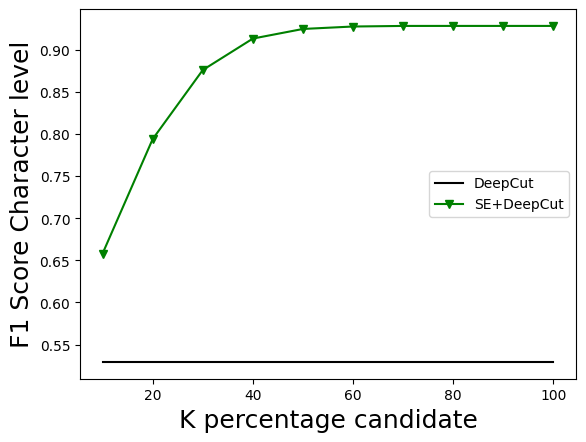

In [11]:
K_num = 100
start = 10
step = 10
f1_original,f1_crf_dg = score_(K_num, start, step, y_true, y_pred, y_entropy, y_prob, crf_model_ds)

In [12]:
max_gap_og = (f1_crf_dg[0]-f1_original[0])*100
index_max_og = start
print(f"BL:{f1_original[0]:.5f}")

for idx,_ in enumerate(f1_crf_dg):
    new_max_og = (f1_crf_dg[idx]-f1_original[idx])*100
    index_now = start+(idx*step)

    if max_gap_og < new_max_og:
        max_gap_og = new_max_og
        index_max_og = index_now
    
    print(f"K:{index_now} CRF_BL:{f1_crf_dg[idx]:.7f} better than:{new_max_og:.4f}")
print(f'index og:{index_max_og} ')

BL:0.52938
K:10 CRF_BL:0.6580704 better than:12.8694
K:20 CRF_BL:0.7939690 better than:26.4593
K:30 CRF_BL:0.8759672 better than:34.6591
K:40 CRF_BL:0.9133122 better than:38.3936
K:50 CRF_BL:0.9247205 better than:39.5344
K:60 CRF_BL:0.9276200 better than:39.8244
K:70 CRF_BL:0.9283099 better than:39.8933
K:80 CRF_BL:0.9283200 better than:39.8944
K:90 CRF_BL:0.9283200 better than:39.8944
K:100 CRF_BL:0.9283200 better than:39.8944
index og:80 


# Evaluation

In [13]:
#Select K
chosen_K = 80

y_pred_CRF_baseline = SERF_CUT(y_entropy, y_pred, y_prob, chosen_K, crf_model_ds)

In [14]:
'''
What we do here is
['สวัสดีชาวไทย','ประเทศไทย'] -> ['สวัสดีชาวไทยประเทศไทย']
Why?
To evaluate word level, the sentence need to concate !! 
Do not use sum() and average F1-score !!!
'''

y_true_1d = [j for sub in y_true for j in sub]
y_pred_1d = [j for sub in y_pred for j in sub]
y_pred_CRF_1d = [j for sub in y_pred_CRF_baseline for j in sub]
x_data = ''
for item in x:
    x_data+=item
    
deepcut_pred = cut([y_pred_1d],[x_data])
answer = cut([y_true_1d],[x_data])
crf_pred = cut([y_pred_CRF_1d],[x_data])

In [15]:
deepcut_list = deepcut_pred[0].split('|')
answer_list = answer[0].split('|')
crf_list = crf_pred[0].split('|')

print(f'DeepCut Char Score: {eval_function([y_true_1d],[y_pred_1d]):.4f}')
print(f'CRF Char Score: {eval_function([y_true_1d],[y_pred_CRF_1d]):.4f}')

print(f'DeepCut Word Score: {evaluate_word(answer_list,deepcut_list):.4f}')
print(f'CRF Word Score: {evaluate_word(answer_list,crf_list):.4f}')

DeepCut Char Score: 0.5294
CRF Char Score: 0.9283
DeepCut Word Score: 0.2803
CRF Word Score: 0.8064


In [16]:
dg_correct = 0 
dg_wrong = 0
ds_correct = 0
ds_wrong = 0

for idx, val in enumerate(y_true_1d):
    
    if y_pred_1d[idx] == val:
        dg_correct +=1
    else:
        dg_wrong +=1

    if y_pred_CRF_1d[idx] == val:
        ds_correct +=1
    else:
        ds_wrong +=1

In [17]:
print(f'All Character:{len(y_true_1d)}')
print(f'DG correct:{dg_correct}\tDG wrong:{dg_wrong} ')
print(f'DS correct:{ds_correct}\tDS wrong:{ds_wrong}')

All Character:26022
DG correct:21328	DG wrong:4694 
DS correct:25004	DS wrong:1018


# Analysis poor word

In [18]:
wrong_pred_idx = visual_wrong_word(answer_list, crf_list)

In [21]:
context_window_before = 10
context_window_after = 10

for i in wrong_pred_idx:
    if i[1]+context_window_after > len(x_data):
        context_window_after = 0

    true = ''
    for p in range(i[0]-context_window_before, i[1]+context_window_after):
        if y_true_1d[p] == 0:
            true += x_data[p]
        else:
            true = '{}|{}'.format(true, x_data[p])

    pred = ''
    for p in range(i[0]-context_window_before, i[1]+context_window_after):
        if y_pred_1d[p] == 0:
            pred += x_data[p]
        else:
            pred = '{}|{}'.format(pred, x_data[p])

    print(f'Actual:\t{true}')
    print(f'Pred:\t{pred}\n')

Actual:	สท|เซ|แด็ท|ยู|เวอ|ไมน|ว็อท|ไอ|ด
Pred:	สทเซแด็ทยูเวอไมน|ว็อทไอด

Actual:	ี|ไอล|เทค|มาย|กลาสเซ็ส|อ๊อฟ|ไอ|ไลค|ฮ
Pred:	ี|ไอลเทคมาย|กลาสเซ็สอ๊อฟ|ไอไลคฮ

Actual:	ป|เพลอิง|อิท|เซฟ|เกิร์ล|เล็ท
Pred:	ปเพลอิง|อิทเซฟเกิร์ล|เล็ท

Actual:	|ยู|อาย|เอนท์|แวริน|นา|นาดา|ยู|เซ
Pred:	ยู|อาย|เอนท์แวรินนานาดา|ยูเซ

Actual:	อนเดอร์ฟูล|ทูไนท์|เล็ท|โก|ออน|เ
Pred:	อนเดอร์ฟูลทูไนท์|เล็ท|โก|ออน|เ

Actual:	|วอนนา|ซี|ฮาว|บิวทิฟูล|ยู|อาร์|อาย|น
Pred:	|วอน|นาซีฮาวบิวทิฟูลยูอาร์|อาย|น

Actual:	|ไลฟ์|อาย|นีด|ทึ|โน|ยัวร์|ลิป
Pred:	ไลฟ์|อาย|นีด|ทึโนยัวร์ลิป

Actual:	|นาว|อาย|โน|อะ|เพอร์เฟคท์|เว|ทู|เล็ท|ยู
Pred:	นาวอายโนอะเพอร์เฟคท์เวทูเล็ทยู

Actual:	|นาว|เฮ|นาว|ยู|โน|เกิรล|โน|เกิ
Pred:	นาวเฮนาวยูโนเกิรลโนเกิ

Actual:	์|น็อตติง|ทู|ลูส|นาว|แด็ท|ไอฟ
Pred:	์|น็อตติง|ทู|ลูสนาวแด็ทไอฟ

Actual:	ู|ไอ|เรียลลิ|ดู|โซ|เมนี่|ติง
Pred:	ู|ไอเรียลลิดู|โซเมนี่|ติง

Actual:	นนา|บี|อะ|บอล|อิทส|กอนา|บี|อะ|บอ
Pred:	น|นาบี|อะบอลอิทสกอนาบีอะบอ

Actual:	ูส|ลีฟ|บัด|ไอ|ดอนท|วันนา|โก|จัส
Pred:	ูสลีฟ|บัด|ไอดอนทวัน|นาโกจัส

Actual:	|ยู|แคน